In [331]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt #For plots

import warnings
warnings.filterwarnings('ignore') #Ignore warnings

from typing import TypeVar #For typing hints
PandasDataFrame = TypeVar('pandas.core.frame.DataFrame') #Define custom dataframe type
PandasSeries = TypeVar('pandas.core.series.Series') #Define custom series type
PyplotAxis = TypeVar('matplotlib.axes._subplots.AxesSubplot') #Define custom pyplot axis

Let us load the dataset

In [332]:
train = pd.read_csv('TitanicData/train.csv')
test = pd.read_csv('TitanicData/test.csv')
df = pd.concat([train, test], ignore_index = True)

In [333]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We can remove the PassengerId column as it has no contribution to predicting the survival of a passenger.

In [334]:
df.drop(['PassengerId'], axis = 1, inplace = True)

## Exploratory Data Analysis

(Important note: Apart from visualization, EDA also involves handling missing values treatment, outlier treatment, so we are going to use only the training data to derive any kind of inferences and the same will just be fitted on the test data. We are doing this to avoid leakage of test data and overfitting. This treatment is also true for validation set, but currently we are not adding that complexity.)    

We will try to analyze the kind, distribution and other statistical features of all the columns.  

In [335]:
train.shape

(891, 12)

In [336]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [337]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


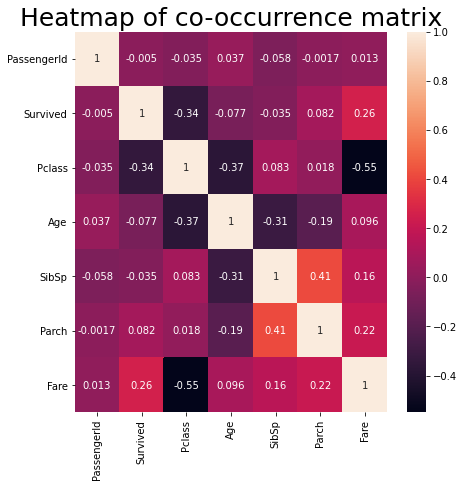

In [338]:
plt.figure(figsize=(7,7))
sns.heatmap(train.corr(method='pearson'), annot=True)
plt.title("Heatmap of co-occurrence matrix", fontsize=25)
plt.show()

Let us now see if we have imbalance in the dataset.  
For this, we will see the distribution of target variable.

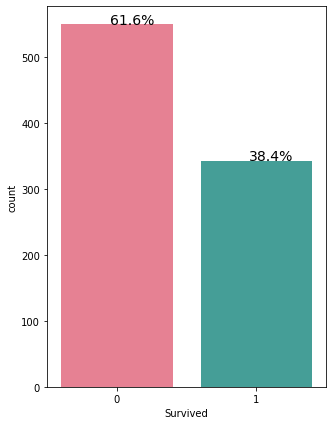

In [339]:
def display_percentage(ax: PyplotAxis, feature: PandasSeries, font_size: int = 14) -> None:
    '''
    This function annotates percentage values of the different bars of a feature 
    on the axes instance that it is provided as input.
    Input:
        ax: Axes instance on which annotation is to be done
        feature: The column of dataset which has been plotted and whose percentage is to be displayed
        font_size: Font size for annotation. Default is 14
    Output: 
        None
    '''
    sum_values = feature.count()
    for p in ax.patches:
        height = p.get_height()
        percentage = f'{height / sum_values * 100:2.1f}%'
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height() + 1
        ax.annotate(percentage, (x, y), size = font_size)

plt.figure(figsize = (5, 7))
ax = sns.countplot(x = train['Survived'], palette = 'husl')
display_percentage(ax, train['Survived'])

The difference in percentage for both values for Survived variable is not significantly large, so we can treat the dataset as balanced.

In [340]:
train.drop(['Survived'], axis = 1).isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

We can see there are 687 missing values in *Cabin* column, which means only 204 values are available to us.  
In *Age* column, we have 177 missing and 714 available values.  
Apart from these, we have 2 values missing for *Embarked* column.

Let us try to visualize this with a heatmap.

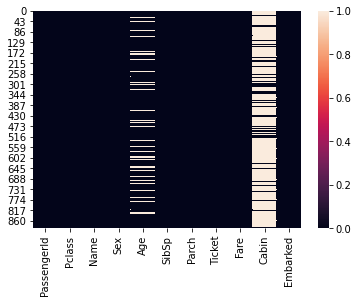

In [341]:
sns.heatmap(train.drop(['Survived'], axis = 1).isna(), cbar=True)
plt.show()

### Missing values in *Cabin* feature

Let us observe the distribution of values in this column first.

In [342]:
train['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

Now let us look at the missing values of cabin column as MNAR. So we are assuming if cabin detail is not available for a person, the person did not occupy any cabin.  




So we will create another derived variable, which will indicate whether the person occupied any cabin or not.  

In [343]:
train['CabinOccupied'] = train['Cabin'].apply(lambda val: 'Not Occupied' if type(val) == float else 'Occupied')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinOccupied
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Not Occupied
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Occupied
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Not Occupied
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Occupied
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Not Occupied


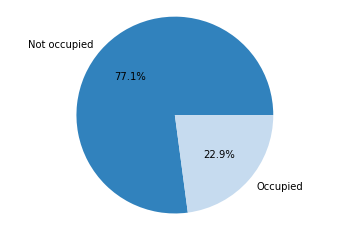

In [344]:
def pie_categorical(df: PandasDataFrame, x_var: str, group_var: str, labels: list = []) -> None:
    '''
    This function plots the pie chart of the aggregate values of a categorical feature from a dataframe.
    eg. the count(aggregate function) of males and females (categorical feature).
    Input:
        df: Dataframe from which plots are to be generated
        x_var: A feature on which pie chart has to be prepared
        group_var: Categorical feature on which aggregation is to be done
        labels: Labels that have to be shown on the different sections of pie chart. 
                Default value is the value saved in the feature column itself
    Output: 
        None
    '''
    df_agg = df[[x_var,group_var]].groupby(group_var).count()
    df_agg.reset_index(inplace = True)
    cmap = plt.get_cmap("tab20c")
    colors = cmap(np.arange(df_agg.shape[0])*3)
    if labels is None or len(labels) is 0:
        labels = df_agg[group_var]
    plt.pie(df_agg[x_var], autopct = '%1.1f%%', colors = colors, labels = labels)
    plt.axis('equal')
    plt.show()
    
pie_categorical(train, 'Pclass', 'CabinOccupied', ['Not occupied', 'Occupied'])

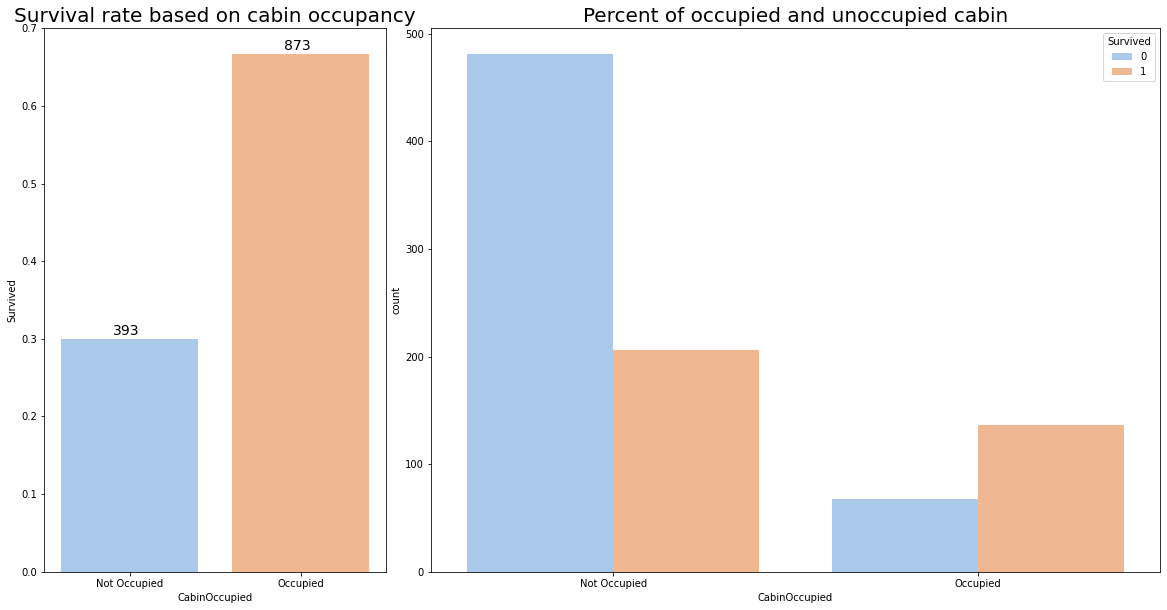

In [345]:
def display_percentage_hued(ax, features, hues, num_x_features, num_hue_features):
    '''
    This function annotates percentage values of the different bars of a feature 
    on the axes instance that it is provided as input, in case of hues in the chart.
    Input:
        ax: Axes instance on which annotation is to be done
        feature: The column of dataset which has been plotted and whose percentage is to be displayed
        font_size: Font size for annotation. Default is 14
    Output: 
        None
    '''
    for x_feature in range(num_x_features):
        sum_values = features.value_counts()[x_feature]
        for hue_feature in range(num_hue_features):
            p = ax.patches[hue_feature*num_x_features + x_feature]
            height = p.get_height()
            percentage = f'{height / sum_values * 100:2.1f}'
            x = p.get_x() + p.get_width() / 2 - 0.1
            y = p.get_y() + p.get_height() + 5
            ax.annotate(percentage, (x, y), size = 14)
        
def display_count(ax):
    '''
    This function annotates count values of the different bars of a feature 
    on the axes instance that it is provided as input.
    Input:
        ax: Axes instance on which annotation is to be done
    Output: 
        None
    '''
    for p in ax.patches:
        number = f'{p.get_height() * df.shape[0]:2.0f}'
        x = p.get_x() + 0.3
        y = p.get_height() + 0.005
        ax.annotate(number, (x, y), size = 14)

plt.figure(figsize = (20, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.2)
plt.subplot(1, 6, (1,2))
ax1 = sns.barplot(x = train['CabinOccupied'], y = train['Survived'], palette = 'pastel', ci = False)
display_count(ax1)
plt.title('Survival rate based on cabin occupancy', size = 20)

plt.subplot(1, 6, (3,6))
ax = sns.countplot(x = train['CabinOccupied'], data = train, palette = 'pastel', hue='Survived')
# display_percentage_hued(ax, df['CabinOccupied'], df['Survived'], 2, 2)
plt.title('Percent of occupied and unoccupied cabin', size = 20)
plt.show()

From the first graph, we can see that the number of people who had occupied the cabin is more than those who did not.  
The second graph tells that people who were not occupying cabins had less chance of survival, since out of the 77% people who were not occupying cabins, only 23% survived, while almost one-



We will now create another derived variable which will tell what cabin type it is, being indicated by the alphabet part of the data in *Cabin* column.  
So we will have Cabin alphabets from A to G and T, and the alphabet N would indicate a NaN or unoccupied value.  

In [346]:
train['CabinLetter'] = train['Cabin'].apply(lambda val: str(val)[0].upper())

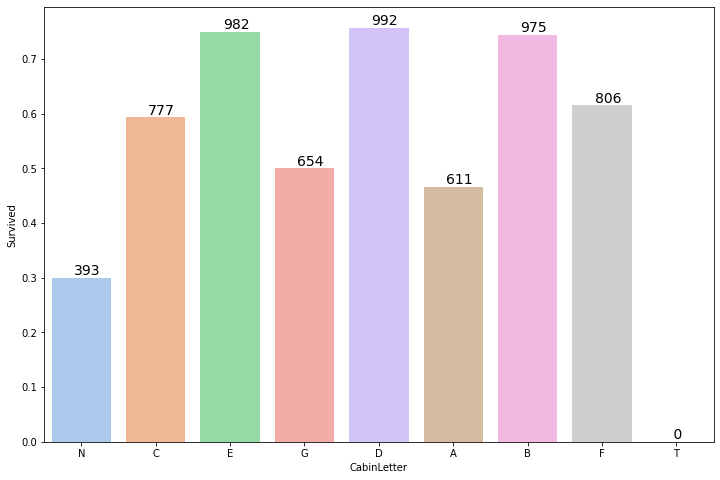

In [347]:
plt.figure(figsize = (12,8))
ax = sns.barplot(x = train['CabinLetter'], y = train['Survived'], palette = 'pastel', ci = False)
display_count(ax)

### Missing values in *Age*  feature

Let us observe the distribution of values in this column first.

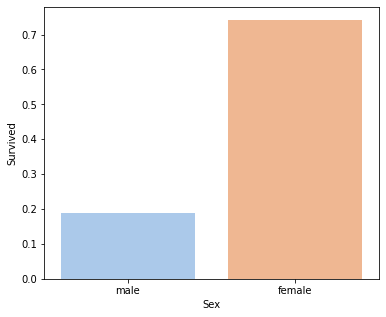

In [348]:
plt.figure(figsize=(6,5))
sns.barplot(x = train['Sex'], y = train['Survived'], palette = 'pastel', ci = False)
plt.xlabel("Sex")
plt.ylabel("Survived")
plt.show()

In [349]:
def stacked_hist(df: PandasDataFrame, vars: list, n_bins: list, subplot_size: tuple, palette: str = 'husl') -> None:
    '''
    This function plots the histogram of binned values of continuous features listed from the dataframe, 
    and stacks the aggregate of another categorical feature for each.
    eg. the count(aggregate function) of males and females (categorical feature) for 
        each age group (continuous feature).
    Input:
        df: Dataframe from which plots are to be generated
        vars: List of tuples in the format (continuous_feature, categorical_feature)
        n_bins: List of bin-sizes for the vars in the same order
        subplot_size: Number of subplots in format (num_rows, num_cols)
        palette: Color palette according to seaborn. Default is husl
    Output: 
        None
    '''
    default_bin_size = 10
    plt.figure(figsize=(10*subplot_size[1], 5*subplot_size[0]), dpi=80)
    for i in range(len(vars)):
        try:
            if len(n_bins) > i:
                bins_num = n_bins[i]
            else:
                bins_num = default_bin_size
            plt.subplot(subplot_size[0], subplot_size[1], i+1)
            df_agg = df.loc[:, [vars[i][0], vars[i][1]]].groupby(vars[i][1])
            vals = [dfa[vars[i][0]].values.tolist() for j, dfa in df_agg]
            colors = [plt.cm.Spectral(j+2/float(len(vals)+10)) for j in range(len(vals))]
            n, bins, patches = plt.hist(vals, bins_num, stacked=True, density=False, color=colors[:len(vals)], edgecolor="k", linewidth=1)
            plt.legend({group:col for group, col in zip(np.unique(df[vars[i][1]]), colors[:len(vals)])})
            plt.title(f"Stacked Histogram of ${vars[i][0]}$ colored by ${vars[i][1]}$", fontsize=22)
            plt.xlabel(vars[i][0])
            plt.ylabel("Frequency")
        except Exception as e:
            print(e)

vars = [
    ('Age', 'Survived'),
#     ('Fare', 'sex')
]
# stacked_hist(df,vars, [30, 30], (2, 1))

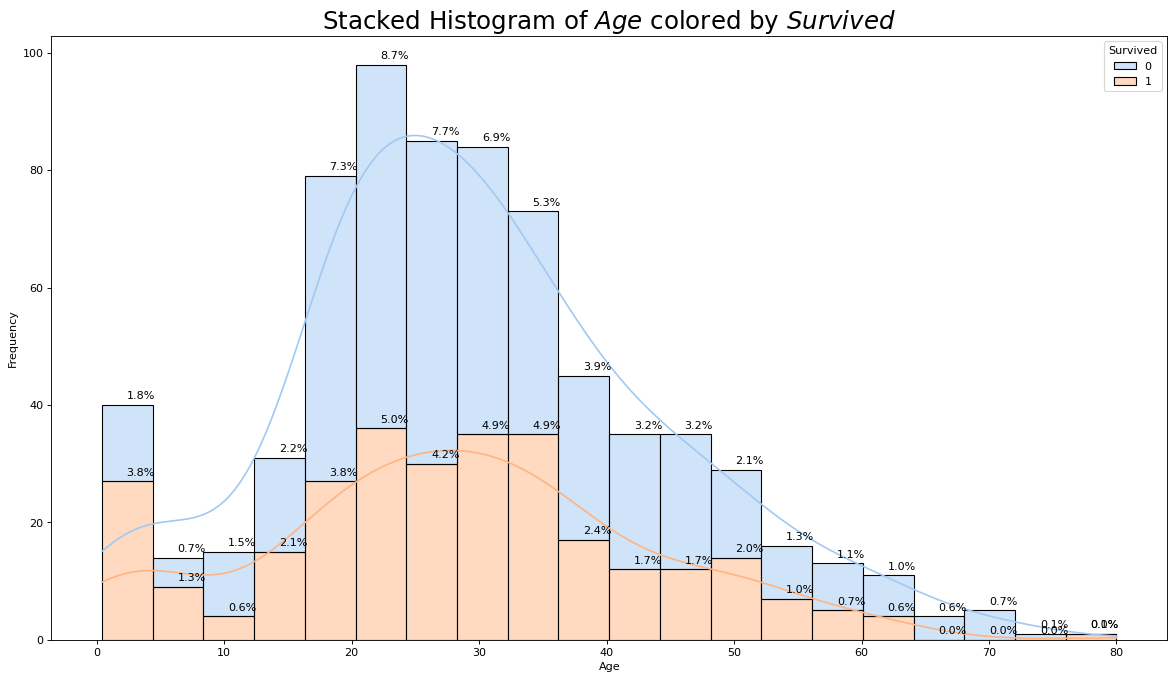

In [350]:
def stacked_hist_sns(df: PandasDataFrame, vars: list, n_bins: list, subplot_size: tuple, palette: str = 'husl') -> None:
    '''
    This function plots the histogram of binned values of continuous features listed from the dataframe, 
    and stacks the aggregate of another categorical feature for each.
    eg. the count(aggregate function) of males and females (categorical feature) for 
        each age group (continuous feature).
    Input:
        df: Dataframe from which plots are to be generated
        vars: List of tuples in the format (continuous_feature, categorical_feature)
        n_bins: List of bin-sizes for the vars in the same order
        subplot_size: Number of subplots in format (num_rows, num_cols)
        palette: Color palette according to seaborn. Default is husl
    Output: 
        None
    '''
    default_bin_size = 10
    plt.figure(figsize=(18*subplot_size[1], 10*subplot_size[0]), dpi=80)
    for i in range(len(vars)):
        try:
            if len(n_bins) > i:
                bins_num = n_bins[i]
            else:
                bins_num = default_bin_size
            plt.subplot(subplot_size[0], subplot_size[1], i+1)
            ax = sns.histplot(x = vars[i][0], data = df, bins = bins_num, hue = 'Survived', kde = True, multiple = 'stack', palette = 'pastel', edgecolor = "k", linewidth=1)
            display_percentage(ax, df[vars[i][0]], 10)
            plt.title(f"Stacked Histogram of ${vars[i][0]}$ colored by ${vars[i][1]}$", fontsize=22)
            plt.xlabel(vars[i][0])
            plt.ylabel("Frequency")
        except Exception as e:
            print(e)
            
vars = [
    ('Age', 'Survived'),
]
stacked_hist_sns(train, vars, [20], (1, 1))

In [351]:
from sklearn.impute import SimpleImputer, KNNImputer

In [352]:
mean_imputer = SimpleImputer(strategy = 'mean')
train['AgeMean'] = mean_imputer.fit_transform(train[['Age']])
train['AgeMean'] = train['AgeMean'].apply(lambda x: int(x))

knn_imputer = KNNImputer(n_neighbors=2, weights="uniform")
train['AgeKNN'] = mean_imputer.fit_transform(train[['Age']])
train['AgeKNN'] = train['AgeKNN'].apply(lambda x: int(x))

train.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinOccupied,CabinLetter,AgeMean,AgeKNN
162,163,0,3,"Bengtsson, Mr. John Viktor",male,26.0,0,0,347068,7.7750,NaN,S,Not Occupied,N,26,26
490,491,0,3,"Hagland, Mr. Konrad Mathias Reiersen",male,NaN,1,0,65304,19.9667,NaN,S,Not Occupied,N,29,29
143,144,0,3,"Burke, Mr. Jeremiah",male,19.0,0,0,365222,6.7500,NaN,Q,Not Occupied,N,19,19
806,807,0,1,"Andrews, Mr. Thomas Jr",male,39.0,0,0,112050,0.0000,A36,S,Occupied,A,39,39
326,327,0,3,"Nysveen, Mr. Johan Hansen",male,61.0,0,0,345364,6.2375,NaN,S,Not Occupied,N,61,61


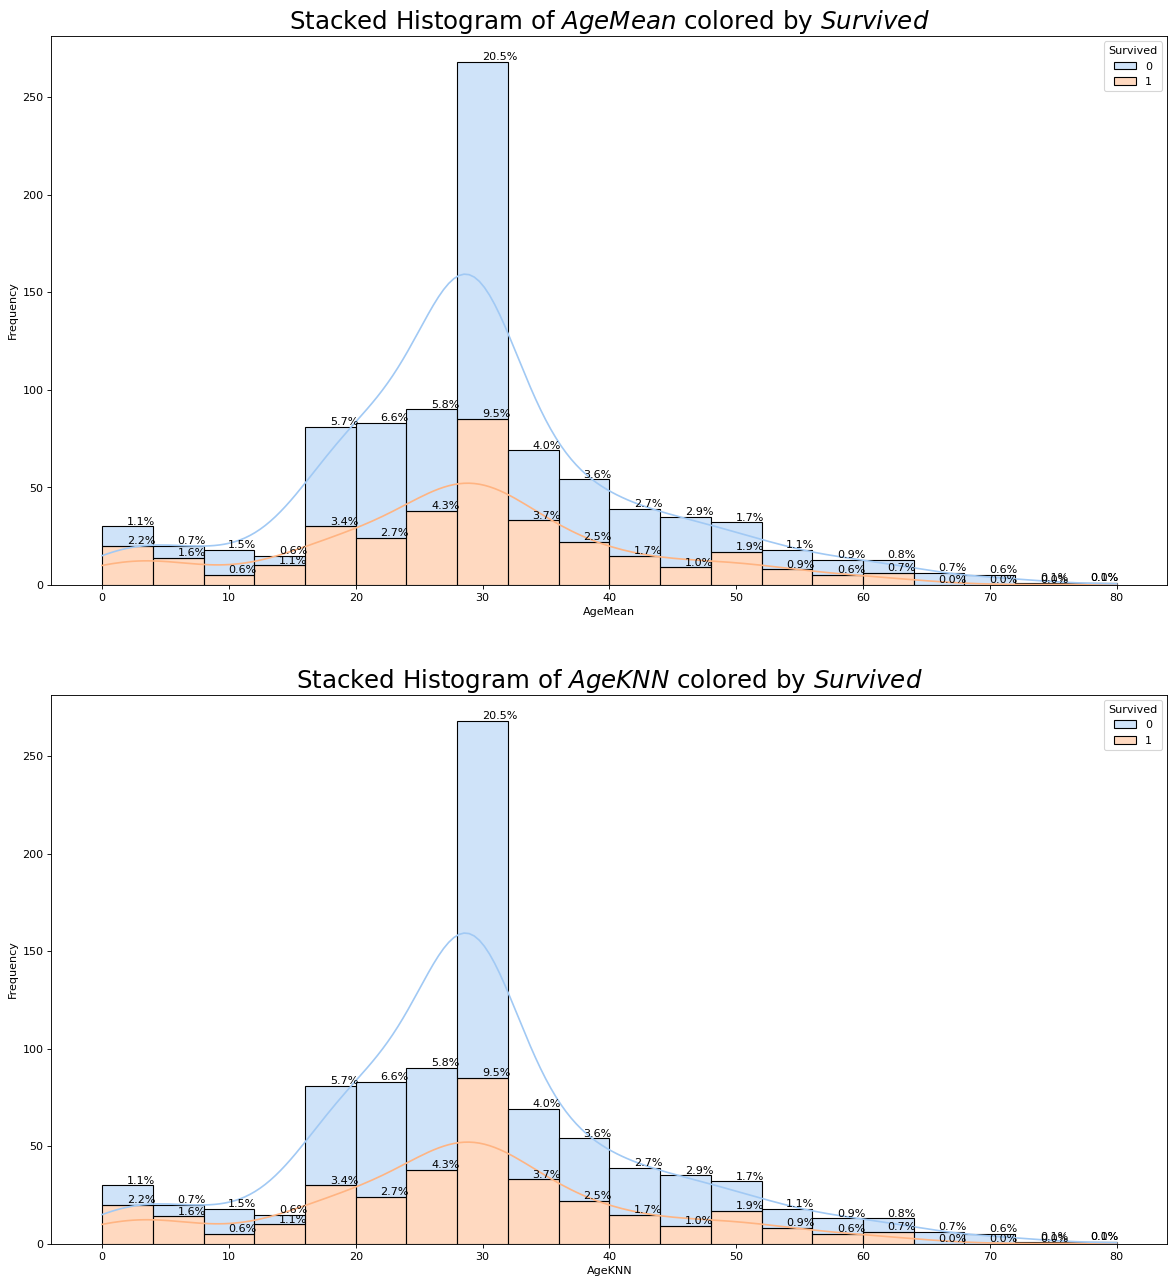

In [353]:
vars = [
    ('AgeMean', 'Survived'),
    ('AgeKNN', 'Survived')
]
stacked_hist_sns(train, vars, [20, 20], (2, 1))

In [354]:
df_agg = train[['Age', 'Sex']].groupby('Sex')
means = []
medians = []

for key, group in df_agg:
    means.append(group['Age'].mean())
    medians.append(group['Age'].median())

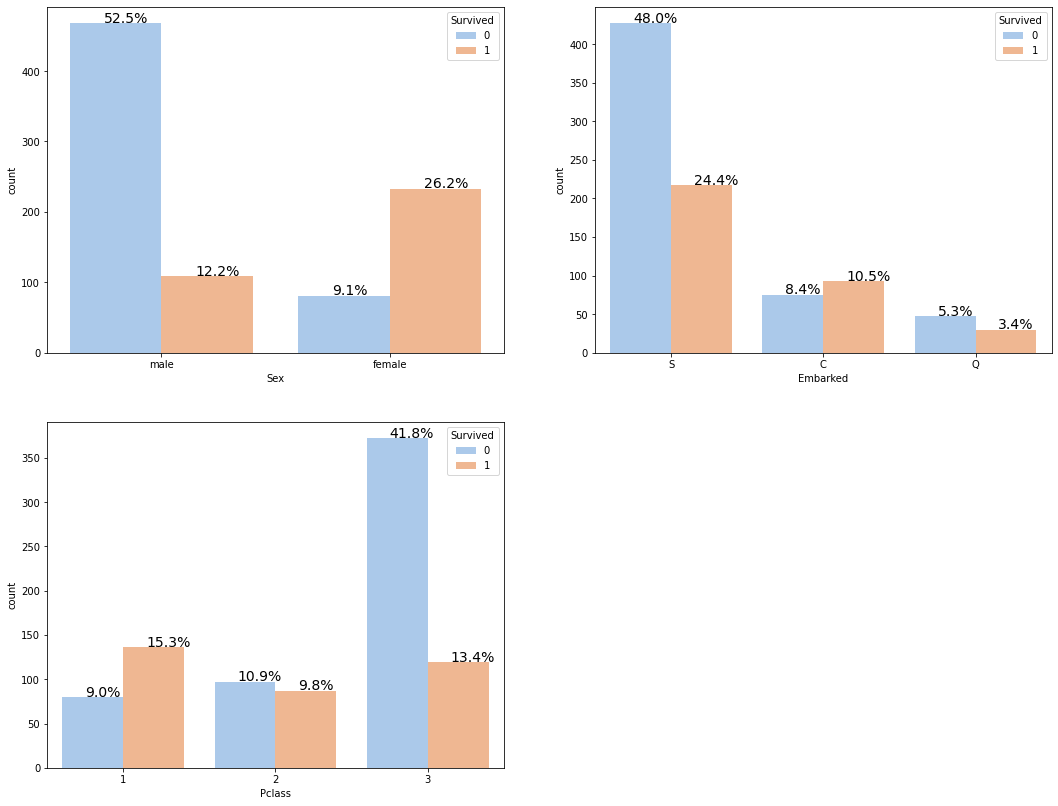

In [355]:
def count_plot(df: PandasDataFrame, x_vars: list, hue: str, subplot_size: tuple, palette: str = 'husl') -> None:
    '''
    This function plots the counts of categorical features listed from the dataframe
    Input:
        df: Dataframe from which plots are to be generated
        x_vars: List of categorical features
        subplot_size: Number of subplots in format (num_rows, num_cols)
        palette: Color palette according to seaborn. Default is husl
    Output: 
        None
    '''
    
    plt.figure(figsize=(9*subplot_size[1], 7*subplot_size[0]))
    for i in range(len(x_vars)):
        try:
            plt.subplot(subplot_size[0], subplot_size[1], i+1)
            ax = sns.countplot(x = df[x_vars[i]], data = df, palette = palette, hue=hue)
            display_percentage(ax, df[x_vars[i]])
            plt.xlabel(x_vars[i])
            plt.ylabel('count')
        except Exception as e:
            print(e)
            
count_plot(train, ['Sex', 'Embarked', 'Pclass'], 'Survived', (2,2), 'pastel')

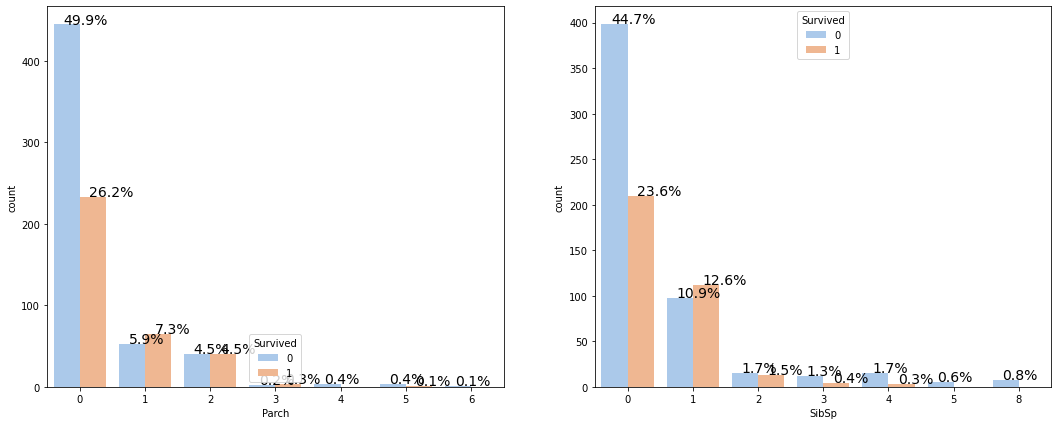

In [356]:
count_plot(train, ['Parch', 'SibSp'], 'Survived', (1,2), 'pastel')

We can see there is a column *Parch* indicating the number of parents/children of the person and *SibSp* indicating the number of siblings/spouses of the person. So we can create another derived variable to store the number of family members for the person.  

In [357]:
train['Family'] = train['Parch'] + train['SibSp']
train.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinOccupied,CabinLetter,AgeMean,AgeKNN,Family
247,248,1,2,"Hamalainen, Mrs. William (Anna)",female,24.0,0,2,250649,14.5000,NaN,S,Not Occupied,N,24,24,2
398,399,0,2,"Pain, Dr. Alfred",male,23.0,0,0,244278,10.5000,NaN,S,Not Occupied,N,23,23,0
424,425,0,3,"Rosblom, Mr. Viktor Richard",male,18.0,1,1,370129,20.2125,NaN,S,Not Occupied,N,18,18,2
268,269,1,1,"Graham, Mrs. William Thompson (Edith Junkins)",female,58.0,0,1,PC 17582,153.4625,C125,S,Occupied,C,58,58,1
219,220,0,2,"Harris, Mr. Walter",male,30.0,0,0,W/C 14208,10.5000,NaN,S,Not Occupied,N,30,30,0


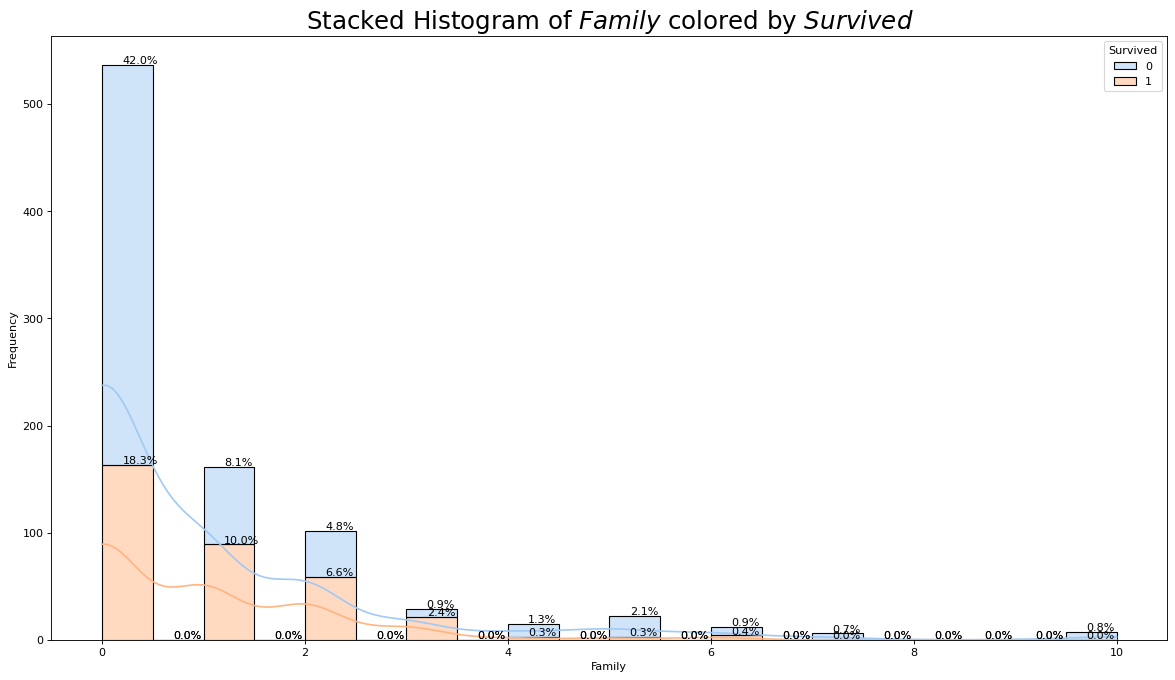

In [358]:
vars = [
    ('Family', 'Survived'),
]
stacked_hist_sns(train, vars, [20], (1, 1))

Here we can see that people with no family members, ie. who were travelling alone had less chance of survival. So we can create another derived variable to indicated that.  

In [359]:
train['Alone'] = 1 
train.loc[train['Family'] > 0, ['Alone']] = 0
train.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinOccupied,CabinLetter,AgeMean,AgeKNN,Family,Alone
746,747,0,3,"Abbott, Mr. Rossmore Edward",male,16.0,1,1,C.A. 2673,20.2500,NaN,S,Not Occupied,N,16,16,2,0
709,710,1,3,"Moubarek, Master. Halim Gonios (""William George"")",male,NaN,1,1,2661,15.2458,NaN,C,Not Occupied,N,29,29,2,0
879,880,1,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56.0,0,1,11767,83.1583,C50,C,Occupied,C,56,56,1,0
365,366,0,3,"Adahl, Mr. Mauritz Nils Martin",male,30.0,0,0,C 7076,7.2500,NaN,S,Not Occupied,N,30,30,0,1
569,570,1,3,"Jonsson, Mr. Carl",male,32.0,0,0,350417,7.8542,NaN,S,Not Occupied,N,32,32,0,1


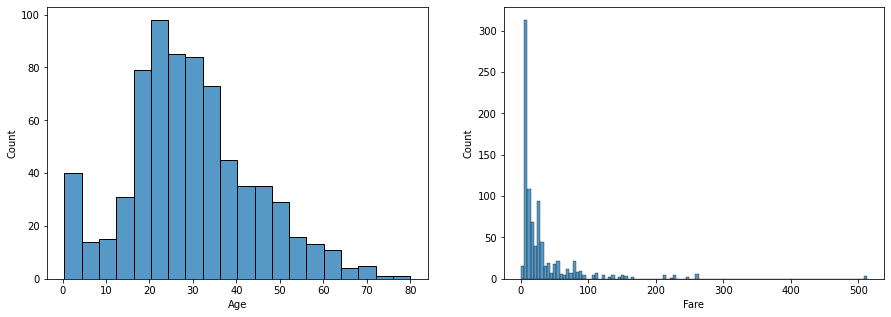

In [360]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.histplot(train['Age'], palette = 'husl')

plt.subplot(1,2,2)
sns.histplot(train['Fare'], palette = 'pastel')
plt.show()